# Uber h3 interpolation

The objective of this notebook is to convert the ERA5 temperature data to a H3 grid.

more info about the grid here:https://h3geo.org/docs/core-library/restable/


In [104]:
#pip install h3
#pip install h3pandas
#pip install geopandas

In [105]:
import pandas as pd
import h3pandas
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import folium
import h3
import shapely.geometry


In [106]:
#Open the data
ds=xr.open_dataset('data/01jan2023.nc')
ds=ds.isel(time=0)
df = ds.to_dataframe().reset_index()
df.columns = ['lng', 'lat', 'time', 'temperature']
del df['time']
df

,lng,lat,temperature
0,0.000,90.000,258.276141
1,0.000,84.375,260.621813
2,0.000,78.750,271.178523
3,0.000,73.125,274.150974
4,0.000,67.500,273.754489
...,...,...,...
2107,354.375,-67.500,271.605872
2108,354.375,-73.125,260.266876
2109,354.375,-78.750,252.246958
2110,354.375,-84.375,251.087180


We have to select a resolution. to easy the process, we could use the bigger one. 

In [107]:
resolution = 0
df = df.h3.geo_to_h3(resolution)
df

,lng,lat,temperature
h3_00,,,
8001fffffffffff,0.000,90.000,258.276141
8001fffffffffff,0.000,84.375,260.621813
8001fffffffffff,0.000,78.750,271.178523
8007fffffffffff,0.000,73.125,274.150974
8009fffffffffff,0.000,67.500,273.754489
...,...,...,...
80effffffffffff,354.375,-67.500,271.605872
80effffffffffff,354.375,-73.125,260.266876
80effffffffffff,354.375,-78.750,252.246958


In [108]:
#since there may be more than one observation per cell, we have to group by mean.

df = df.groupby('h3_00').mean()
gdf = df.h3.h3_to_geo_boundary()
gdf = gdf.reset_index()
gdf

,h3_00,lng,lat,temperature,geometry
0,8001fffffffffff,134.359756,85.198174,260.841800,"POLYGON ((31.83128 68.92996, 62.34534 69.39360..."
1,8003fffffffffff,252.838989,79.798729,245.413014,"POLYGON ((145.55820 87.36470, -163.45687 76.14..."
2,8005fffffffffff,145.534088,76.397728,245.273570,"POLYGON ((94.14309 76.16304, 117.81293 66.2032..."
3,8007fffffffffff,316.158081,70.808823,254.050832,"POLYGON ((0.32561 73.31022, -34.75842 81.27137..."
4,8009fffffffffff,61.071430,64.285713,272.891057,"POLYGON ((-10.44498 63.09505, 5.52365 55.70677..."
...,...,...,...,...,...
117,80ebfffffffffff,189.642853,-64.285713,274.503791,"POLYGON ((-154.91728 -58.40154, -174.47635 -55..."
118,80edfffffffffff,146.746323,-70.808823,261.672519,"POLYGON ((169.55502 -63.09505, 150.11766 -58.0..."
119,80effffffffffff,292.806824,-76.397728,262.157054,"POLYGON ((-34.44180 -87.36470, 16.54313 -76.14..."
120,80f1fffffffffff,72.838982,-79.798729,246.994930,"POLYGON ((145.24158 -81.27137, 113.09550 -72.2..."


Now we can plot it

<Axes: >

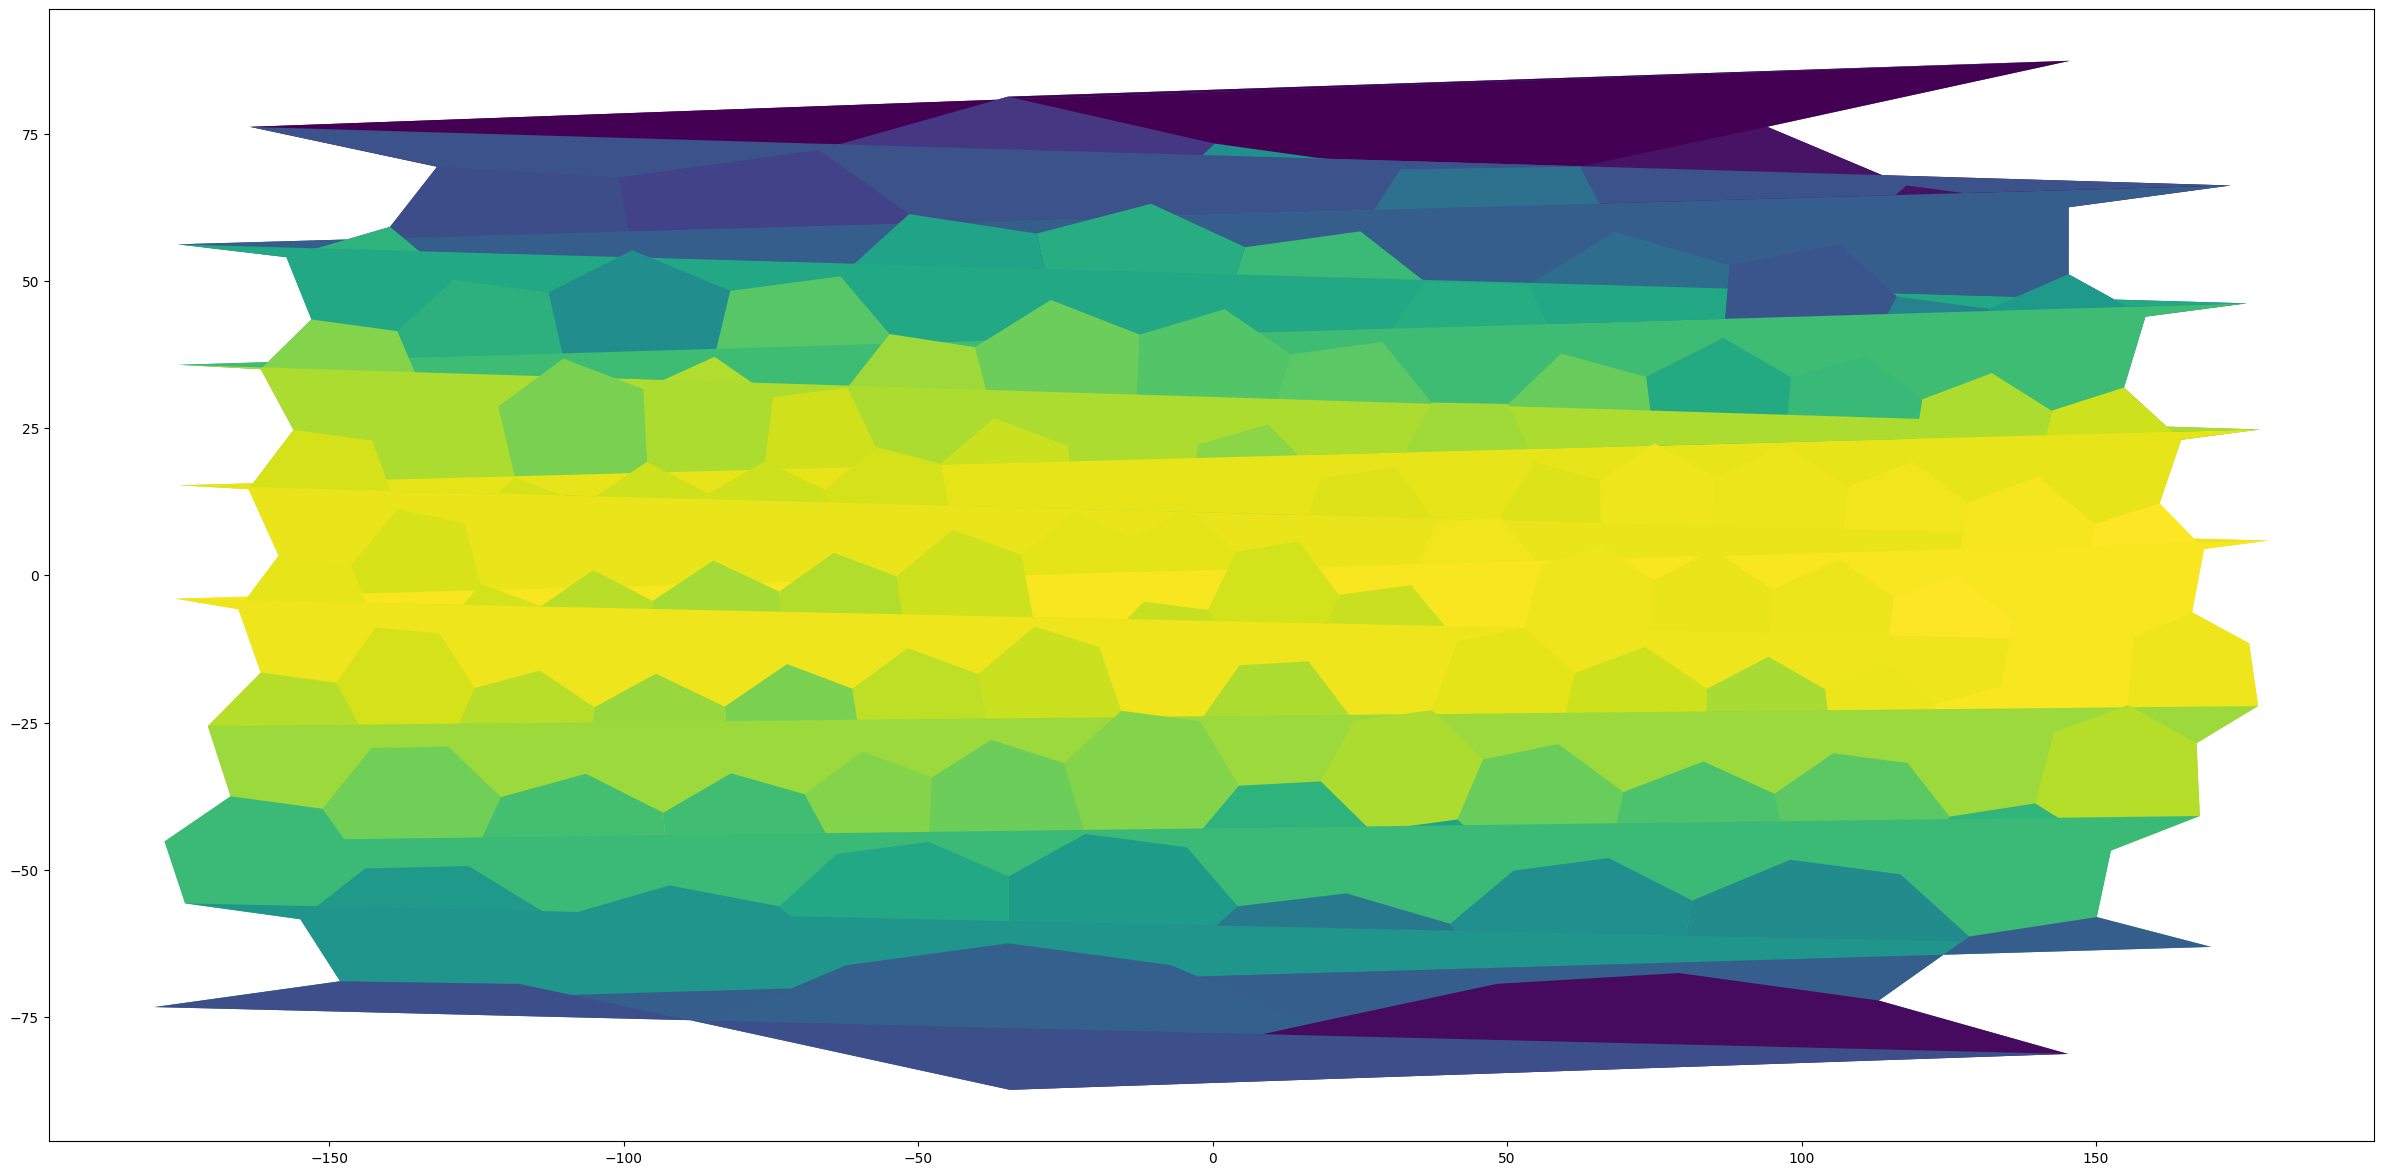

In [109]:
gdf.plot(column='temperature', figsize=(30, 30))

This plot does not work, since probably the hexagons at the antimeridian are divided, with lines conecting them in both extremes. We have to fix the issue, for which exist the library antimeridian

In [110]:
import antimeridian


#geometry = gdf.geometry

#for geom in geometry:
#    antimeridian.fix_polygon(geom)

#gdf.geometry[1] 

for i in range(len(gdf2)):
    gdf.geometry.iloc[i] = antimeridian.fix_polygon(gdf.geometry.iloc[i])

/tmp/ipykernel_17720/825252779.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  gdf.geometry.iloc[i] = antimeridian.fix_polygon(gdf.geometry.iloc[i])


Now we can plot it correctly, and use the interactive leaflets maps.

In [111]:

# create a Folium map
m = folium.Map(location=[0, 0], zoom_start=2)

linear = cm.LinearColormap(["blue", "yellow", "red"], vmin=min(gdf.temperature), vmax=max(gdf.temperature))
myscale = (gdf['temperature'].quantile((0,0.2,0.4,0.6,0.8,1))).tolist()


# add a choropleth layer to the map (original data)
folium.Choropleth(
 geo_data=gdf,
 name='Choropleth',
 data=gdf,
 columns=['h3_00','temperature'],
 key_on="feature.properties.h3_00",
 fill_color='OrRd',
 threshold_scale=myscale,
 fill_opacity=0.5,
 line_opacity=0.2,
 legend_name='Temperature in K',
 smooth_factor=0
).add_to(m)

# display the map
m

A second step could be use a higher resolution

<Axes: >

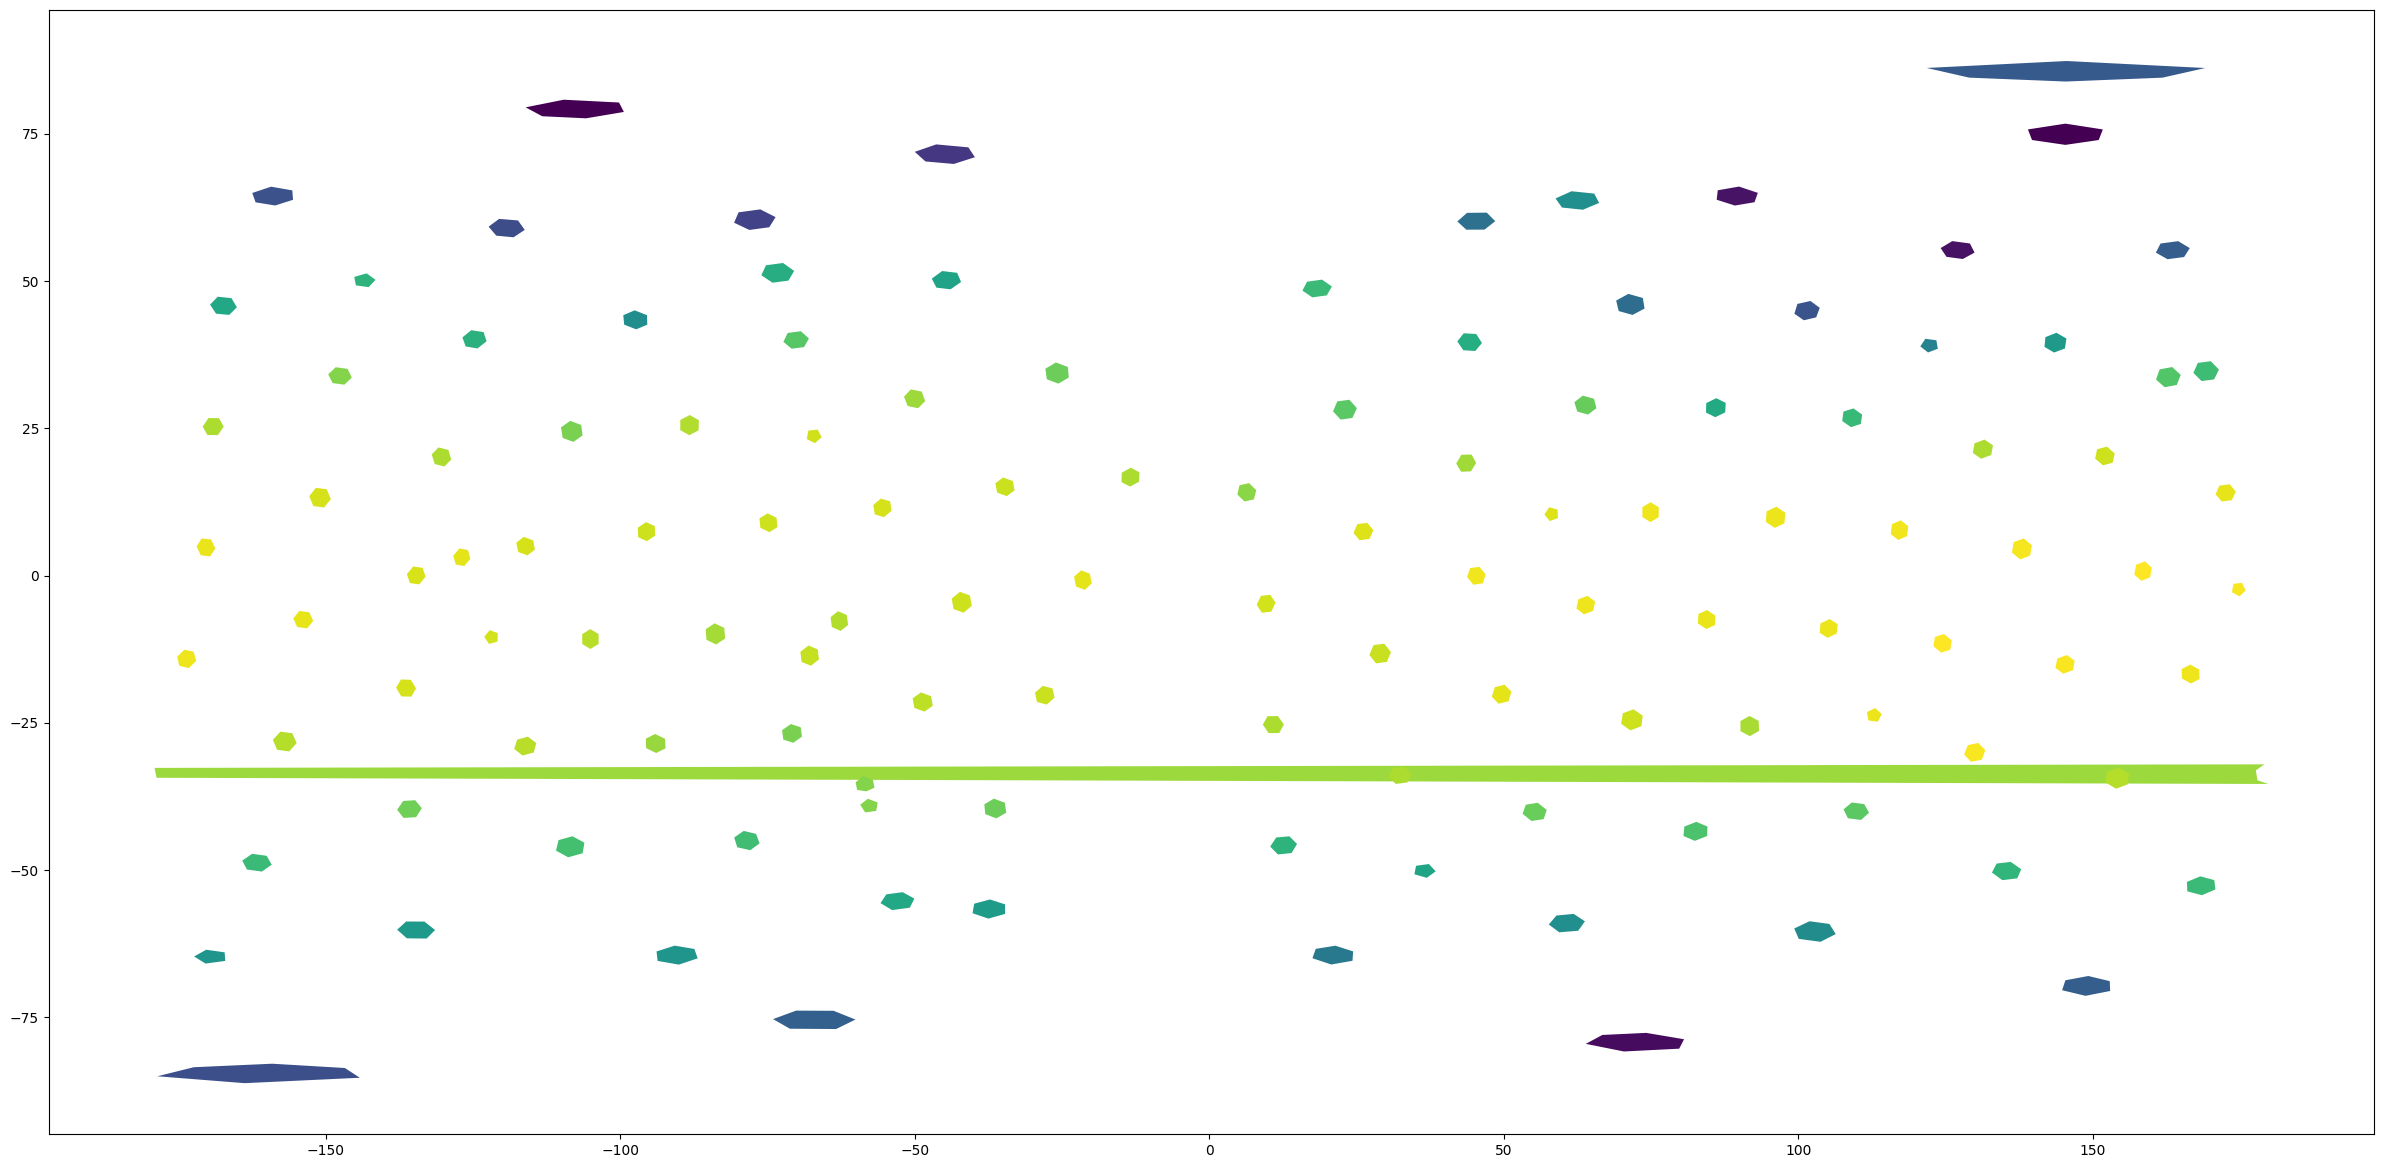

In [118]:
resolution =2
df = df.h3.geo_to_h3(resolution)
df = df.groupby('h3_02').mean()
gdf = df.h3.h3_to_geo_boundary()
gdf = gdf.reset_index()
gdf.plot(column='temperature', figsize=(30, 30))

We can see not all cells cover the Earth, therefore is necesary an interpolation. For this, future steps could be creating a grid that covers all earth, extract the centroids of each, and interpolate using the existing observations. a good algorith could be Krigging, with wich we could obtain information in all the cells. 